OJO: one-hot funciona bien en general, aunque si pusiera label encoder en ciertas variables en las que usé one-hot podría ser mejorpara arboles

OJO2: si los modelos son un cagarro, corregir colver a data_cleaning y corregir class imbalance puede ayudar

In [12]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
import xgboost as xgb
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

In [13]:
train_df = pd.read_csv('clean_train_df.csv')
test_df = pd.read_csv('clean_test_df.csv')
train_df.shape, test_df.shape

((2244, 76), (543, 76))

In [14]:
'''# Assuming you have a DataFrame called 'df'
baseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]

# Add Job_title columns to the baseline_cols list
Job_title = ['Developer, game or graphics', 'Blockchain', 'Developer, QA or test', 'Developer, back-end', 'Student', 
             'Project manager', 'Data or business analyst', 'Cloud infrastructure engineer', 'Engineer, data', 
             'Educator', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Designer', 
             'Security professional', 'Developer, embedded applications or devices', 'Product manager', 'Developer, mobile', 
             'Developer, full-stack', 'Scientist', 'Database administrator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 
             'Marketing or sales professional', 'System administrator', 'Data scientist or machine learning specialist', 
             'Engineer, site reliability', 'DevOps specialist', 'Engineering manager']

baseline_cols.extend(Job_title)

# Iterate through the columns and keep only those containing the specified keywords
columns_to_keep_train = [col for col in train_df.columns if any(keyword in col for keyword in baseline_cols)]
columns_to_keep_test = [col for col in test_df.columns if any(keyword in col for keyword in baseline_cols)]

# Filter the DataFrame, keeping only the selected columns
baseline_train_df = train_df[columns_to_keep_train]
baseline_test_df = test_df[columns_to_keep_test]

baseline_train_df.head()'''

'# Assuming you have a DataFrame called \'df\'\nbaseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]\n\n# Add Job_title columns to the baseline_cols list\nJob_title = [\'Developer, game or graphics\', \'Blockchain\', \'Developer, QA or test\', \'Developer, back-end\', \'Student\', \n             \'Project manager\', \'Data or business analyst\', \'Cloud infrastructure engineer\', \'Engineer, data\', \n             \'Educator\', \'Developer, desktop or enterprise applications\', \'Developer, front-end\', \'Designer\', \n             \'Security professional\', \'Developer, embedded applications or devices\', \'Product manager\', \'Developer, mobile\', \n             \'Developer, full-stack\', \'Scientist\', \'Database administrator\', \'Academic researcher\', \'Senior Executive (C-Suite, VP, etc.)\', \n             \'Marketing or sales professional\', \'System administrator\', \'Data scientist or machine learning specialist\', \n

In [15]:
X_train = train_df.drop('Annual_salary', axis=1)
X_test = test_df.drop('Annual_salary', axis=1)
y_train = train_df['Annual_salary']
y_test = test_df['Annual_salary']

In [16]:
'''X_train = baseline_train_df.drop('Annual_salary', axis=1)
X_test = baseline_test_df.drop('Annual_salary', axis=1)
y_train = baseline_train_df['Annual_salary']
y_test = baseline_test_df['Annual_salary']

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)'''

"X_train = baseline_train_df.drop('Annual_salary', axis=1)\nX_test = baseline_test_df.drop('Annual_salary', axis=1)\ny_train = baseline_train_df['Annual_salary']\ny_test = baseline_test_df['Annual_salary']\n\nprint(X_train.shape)\nprint(y_train.shape)\nprint()\nprint(X_test.shape)\nprint(y_test.shape)"

In [17]:
# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [i for i in range(X_train.shape[1]) if i != X_train.columns.get_loc("Country")]),
        ('cat', OneHotEncoder(handle_unknown='ignore'), [X_train.columns.get_loc("Country")])
    ])

# Create a pipeline with preprocessing and XGBoost model
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Define the parameter distribution you want to explore
param_dist = {
    "model__n_estimators": randint(50, 500),
    "model__learning_rate": uniform(0.01, 0.3),
    "model__max_depth": randint(1, 20),
    "model__min_child_weight": randint(1, 10),
    "model__gamma": uniform(0, 1),
    "model__subsample": uniform(0.5, 0.5),
    "model__colsample_bytree": uniform(0.5, 0.5),
}

# with normal KFold
random_search = RandomizedSearchCV(
    xgb_pipeline, param_distributions=param_dist, n_iter=50, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring="r2", n_jobs=-1, random_state=42, verbose=2
)

# with StratifiedKFold
'''y_bins = pd.qcut(y_train, q=20, labels=False)

random_search = RandomizedSearchCV(
    xgb_pipeline, param_distributions=param_dist, n_iter=50, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_train, y_bins), 
    scoring="r2", n_jobs=-1, random_state=42, verbose=2
)'''

# Fit the model using RandomizedSearchCV
random_search.fit(X_train, y_train, model__eval_metric = 'rmse')

# Print the best hyperparameters found
print("Best hyperparameters found:")
best_params = random_search.best_params_
print(best_params)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\fenan\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Best hyperparameters found:
{'model__colsample_bytree': 0.5077283082644337, 'model__gamma': 0.9283185625877254, 'model__learning_rate': 0.1384552444951943, 'model__max_depth': 3, 'model__min_child_weight': 1, 'model__n_estimators': 165, 'model__subsample': 0.6472244460347929}


In [18]:
print(

SyntaxError: unexpected EOF while parsing (149104261.py, line 1)

In [22]:
# Create the pipeline: preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params))
])

# Define scoring metrics for cross-validation
scoring = {'r2': make_scorer(r2_score), 'rmse': make_scorer(mean_squared_error, squared=False), 'mae': make_scorer(mean_absolute_error)}

# Perform cross-validation using KFold
scores = cross_validate(pipeline, X_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring=scoring)

# Using StratifiedKFold
'''scores = cross_validate(pipeline, X_train, y_train, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_train, y_bins), 
    scoring=scoring
)'''


print("Cross-validation performance:")
print(f"Average R2 (XGBoost): {scores['test_r2'].mean():.3f} (+/- {scores['test_r2'].std():.3f})")
print(f"Average RMSE (XGBoost): {scores['test_rmse'].mean():.3f} (+/- {scores['test_rmse'].std():.3f})")
print(f"Average MAE (XGBoost): {scores['test_mae'].mean():.3f} (+/- {scores['test_mae'].std():.3f})")

# Train the model using the full training dataset
pipeline.fit(X_train, y_train)

# Make predictions on the test dataset
y_pred = pipeline.predict(X_test)

# Compute performance metrics on the test dataset
r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
n_test = X_test.shape[0]
p_test = X_train.shape[1]  # use the original training data shape for the number of predictors
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

print("\nTest dataset performance:")
print(f"R2 (XGBoost): {r2_test:.3f}")
print(f"Adjusted R2 (XGBoost): {adjusted_r2_test:.3f}")
print(f"RMSE (XGBoost): {rmse_test:.3f}")
print(f"MAE (XGBoost): {mae_test:.3f}")

[21:40:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "model__colsample_bytree", "model__gamma", "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model__subsample" } are not used.

[21:40:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "model__colsample_bytree", "model__gamma", "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model__subsample" } are not used.

[21:40:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "model__colsample_bytree", "model__gamma", "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model_

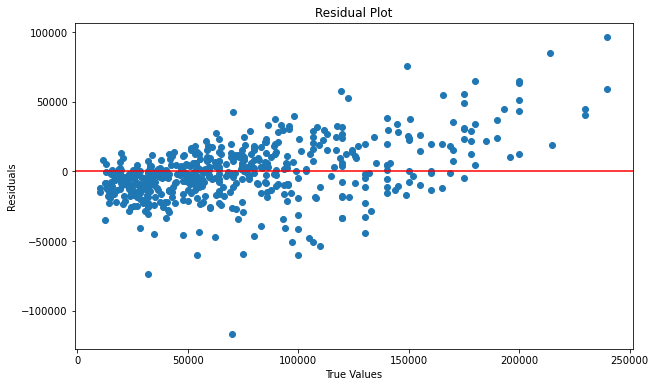

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [ ]:
# Get feature importances
importances = pipeline.named_steps['model'].feature_importances_

# Create a DataFrame with features and importances
importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Sort by importance
importance_df = importance_df.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importances')
plt.show()


ValueError: All arrays must be of the same length

In [ ]:
'''import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Definir la distribución de los hiperparámetros que deseas explorar
param_dist = {
    "n_estimators": randint(50, 500),
    "learning_rate": uniform(0.01, 0.3),
    "max_depth": randint(1, 20),
    "min_child_weight": randint(1, 10),
    "gamma": uniform(0, 1),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": uniform(0.5, 0.5),
}

# Crear el objeto del modelo XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Crear el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, n_iter=50, cv=5, scoring="r2", n_jobs=-1, random_state=42, verbose=2
)

# Ajustar el modelo utilizando RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Crear el modelo con los mejores hiperparámetros
best_xgb_model = random_search.best_estimator_'''


'import numpy as np\nimport xgboost as xgb\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import randint, uniform\n\n# Definir la distribución de los hiperparámetros que deseas explorar\nparam_dist = {\n    "n_estimators": randint(50, 500),\n    "learning_rate": uniform(0.01, 0.3),\n    "max_depth": randint(1, 20),\n    "min_child_weight": randint(1, 10),\n    "gamma": uniform(0, 1),\n    "subsample": uniform(0.5, 0.5),\n    "colsample_bytree": uniform(0.5, 0.5),\n}\n\n# Crear el objeto del modelo XGBoost\nxgb_model = xgb.XGBRegressor(objective=\'reg:squarederror\', random_state=42)\n\n# Crear el objeto RandomizedSearchCV\nrandom_search = RandomizedSearchCV(\n    xgb_model, param_distributions=param_dist, n_iter=50, cv=5, scoring="r2", n_jobs=-1, random_state=42, verbose=2\n)\n\n# Ajustar el modelo utilizando RandomizedSearchCV\nrandom_search.fit(X_train_scaled, y_train)\n\n# Mostrar los mejores hiperparámetros encontrados\nprint("Mejores hiperparámetros enco

In [ ]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

'''best_params = {'colsample_bytree': 0.9828160165372797, 
               'gamma': 0.8083973481164611, 'learning_rate': 0.10138413075201119, 
               'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 141, 'subsample': 0.7200762468698007}'''

best_params = {'colsample_bytree': 0.9828160165372797, 
               'gamma': 0.8083973481164611, 'learning_rate': 0.10138413075201119, 
               'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 141, 'subsample': 0.7200762468698007}

k = 5
num_val_samples = X_train_scaled.shape[0] // k
all_scores_r2 = []
all_scores_adjusted_r2 = []
all_scores_rmse = []
all_scores_mae = []

from scipy.sparse import vstack

for i in range(k):
    print('processing fold #', i)
    val_data = X_train_scaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = vstack([X_train_scaled[:i * num_val_samples],
                                 X_train_scaled[(i + 1) * num_val_samples:]])
    partial_train_targets = pd.concat([y_train[:i * num_val_samples],
                                       y_train[(i + 1) * num_val_samples:]])

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
    model.fit(partial_train_data, partial_train_targets)

    val_preds = model.predict(val_data)
    r2_val = r2_score(val_targets, val_preds)
    n = val_data.shape[0]
    p = val_data.shape[1]
    adjusted_r2_val = 1 - (1 - r2_val) * (n - 1) / (n - p - 1)
    rmse_val = np.sqrt(mean_squared_error(val_targets, val_preds))
    mae_val = mean_absolute_error(val_targets, val_preds)

    all_scores_r2.append(r2_val)
    all_scores_adjusted_r2.append(adjusted_r2_val)
    all_scores_rmse.append(rmse_val)
    all_scores_mae.append(mae_val)

mean_r2 = np.mean(all_scores_r2)
std_r2 = np.std(all_scores_r2)
mean_adjusted_r2 = np.mean(all_scores_adjusted_r2)
std_adjusted_r2 = np.std(all_scores_adjusted_r2)
mean_rmse = np.mean(all_scores_rmse)
std_rmse = np.std(all_scores_rmse)
mean_mae = np.mean(all_scores_mae)
std_mae = np.std(all_scores_mae)
print(f"Rendimiento promedio R2 (XGBoost): {mean_r2:.3f} (+/- {std_r2:.3f})")
print(f"Rendimiento promedio R2 ajustado (XGBoost): {mean_adjusted_r2:.3f} (+/- {std_adjusted_r2:.3f})")
print(f"Rendimiento promedio RMSE (XGBoost): {mean_rmse:.3f} (+/- {std_rmse:.3f})")
print(f"Rendimiento promedio MAE (XGBoost): {mean_mae:.3f} (+/- {std_mae:.3f})")


processing fold # 0


XGBoostError: [13:46:55] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\data\data.cc:455: Check failed: this->labels.Size() % this->num_row_ == 0 (1798 vs. 0) : Incorrect size for labels.

In [ ]:
xgb_results_dic = {}

xgb_results_dic['XGBoost'] = {'R2': mean_r2, 'Adj R2': mean_adjusted_r2, 'RMSE': mean_rmse, 'MAE': mean_mae}
xgb_results  = pd.DataFrame.from_dict(xgb_results_dic, orient='index')
xgb_results 

,R2,Adj R2,RMSE,MAE
XGBoost,0.115466,-0.24664,36554.813989,28225.270313


In [ ]:
xgb_results.to_csv('xgb_results.csv', index=True)

In [ ]:
# Entrenar el modelo utilizando el conjunto de datos de entrenamiento completo
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
model.fit(X_train_scaled, y_train)

# Hacer predicciones en el conjunto de datos de prueba
y_pred = model.predict(X_test_scaled)

# Calcular métricas de rendimiento en el conjunto de datos de prueba
r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
n_test = X_test_scaled.shape[0]  # change this line
p_test = X_train_scaled.shape[1]  # use the original training data shape for the number of predictors
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

print(f"Rendimiento R2 en el conjunto de prueba (XGBoost): {r2_test:.3f}")
print(f"Rendimiento adjusted R2 en el conjunto de prueba (XGBoost): {adjusted_r2_test:.3f}")
print(f"Rendimiento RMSE en el conjunto de prueba (XGBoost): {rmse_test:.3f}")
print(f"Rendimiento MAE en el conjunto de prueba (XGBoost): {mae_test:.3f}")



Rendimiento R2 en el conjunto de prueba (XGBoost): 0.604
Rendimiento adjusted R2 en el conjunto de prueba (XGBoost): 0.476
Rendimiento RMSE en el conjunto de prueba (XGBoost): 30432.333
Rendimiento MAE en el conjunto de prueba (XGBoost): 22979.509


In [ ]:
y_test.shape

(538,)

In [ ]:
y_pred.shape

(538,)

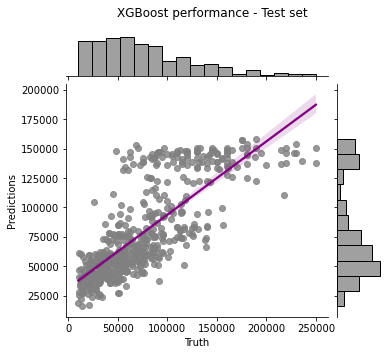

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una cuadrícula de gráficos conjunta y configurar los ejes para los histogramas
g = sns.JointGrid(x=y_test, y=y_pred, height=5)

# Crear un gráfico de dispersión y ajustar una línea de regresión lineal a los datos
g.plot_joint(sns.regplot, scatter_kws={'color': 'grey'}, line_kws={'color': 'purple'})

# Agregar histogramas en la parte superior y en el lado derecho del gráfico
g.plot_marginals(sns.histplot, kde=False, color='grey')

# Ajustar el espacio entre los subgráficos y mover el título hacia arriba
g.fig.subplots_adjust(top=0.9)

# Agregar título
g.fig.suptitle("XGBoost performance - Test set")

# Etiquetar los ejes
g.ax_joint.set_xlabel("Truth")
g.ax_joint.set_ylabel("Predictions")

plt.show()
